In [1]:
# Organización de datos
import pandas as pd
import numpy as np
import sympy

# Visualizacicón de datos
import matplotlib
import matplotlib.pyplot as plt
import os

# Cálculo de ajustes matemáticos a los datos
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Funciones
import funciones as f

### 1. Leer y organizar el archivo que contiene los datos de absorbancia

**Unas primeras consideraciones:**

El archivo Excel debe estar organizado en 4 hojas: tiempo 0, tiempo 1, tiempo 2 y tiempo 3

Cada hoja debe tener una primera columna "uM" que indique la concentración de fármaco. Las siguientes se nombraran de la siguiente forma: R1,R2,R3,R4,R1,R2,R3,R4,R1,R2,R3,R4; ya que son las 3 réplicas de lectura consecutivas.

Se supone que la absorbancia a tiempo 0 es la misma para todas las concentraciones de fármaco, ya que se mide antes de añadir el tratamiento.

Se recomienda no trabajar con los datos de absorbancia que tengan más de 0.150 de diferencia con sus réplicas biológicas. Aquellos datos que se eliminen en Excel serán rellenados por la media de las réplicas en el programa.

In [2]:
df = f.read_file('Ensayo A.xlsx')

Obtengo una lista con los DataFrames de los datos de absorbancia a los distintos tiempos: 
- A tiempo cero
- A las 24 horas
- A las 48 horas
- A las 72 horas

In [3]:
df

[             R1        R2    R3
 uM                             
 0.0000    0.764  0.748667  0.78
 1.5625    0.764  0.748667  0.78
 3.1250    0.764  0.748667  0.78
 6.2500    0.764  0.748667  0.78
 12.5000   0.764  0.748667  0.78
 25.0000   0.764  0.748667  0.78
 50.0000   0.764  0.748667  0.78
 100.0000  0.764  0.748667  0.78
 150.0000  0.764  0.748667  0.78,
                 R1        R2        R3
 uM                                    
 0.0000    1.251333  1.284667  1.290000
 1.5625    1.074000  1.160667  0.965333
 3.1250    1.082667  1.052000  1.067333
 6.2500    1.052000  1.005333  0.962667
 12.5000   0.987333  0.976667  0.971333
 25.0000   0.998667  0.943333  0.870000
 50.0000   0.728667  0.712500  0.720833
 100.0000  0.623000  0.584000  0.599000
 150.0000  0.542667  0.577000  0.563333,
                 R1        R2        R3
 uM                                    
 0.0000    1.460667  1.486667  1.446000
 1.5625    1.377333  1.340667  1.336667
 3.1250    1.268667  1.262667  1.29

### 2. Obtener la tasa de crecimiento de las células control

Debemos asegurarnos de que las células que no se han tratado con quimioterapia crecen ajustándose a una exponencial, ya que es el comportamiento que las células tumorales deberían seguir si no se ven afectadas por otros factores.

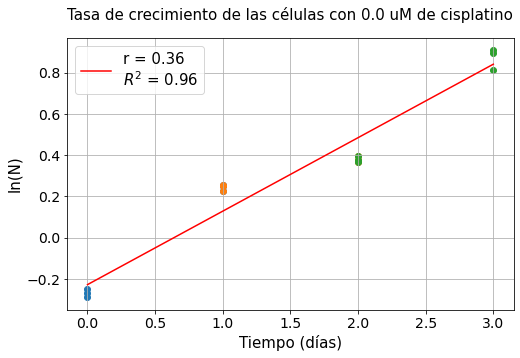

(0.3561526983832144, 0.007188814565686094)

In [4]:
f.r_total(df,0)

Vemos que sí es el caso, por lo tanto continúo trabajando con los datos.

Además, voy a comprobar que pueda seguir usando el ajuste exponencial para las células que se han tratado con quimioterapia.

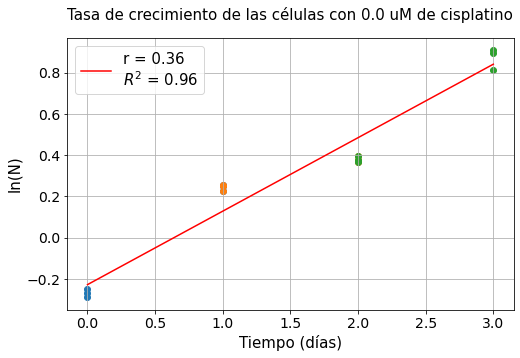

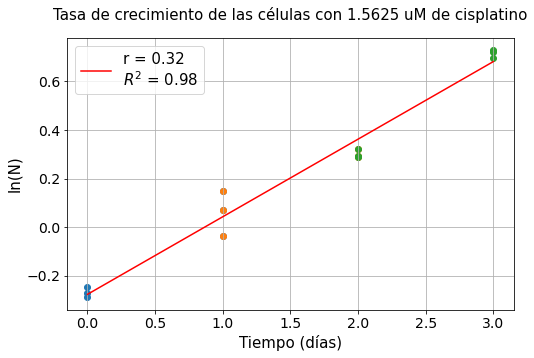

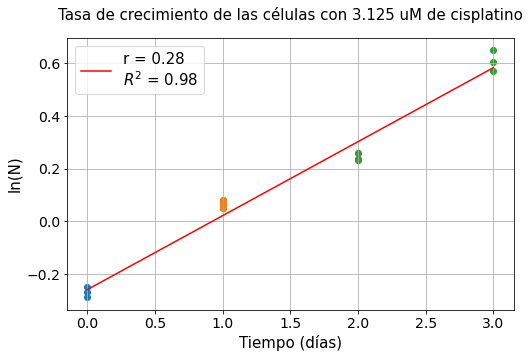

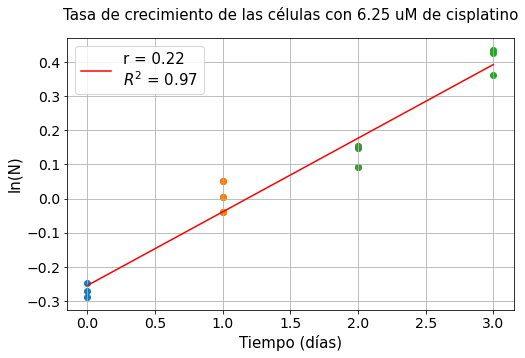

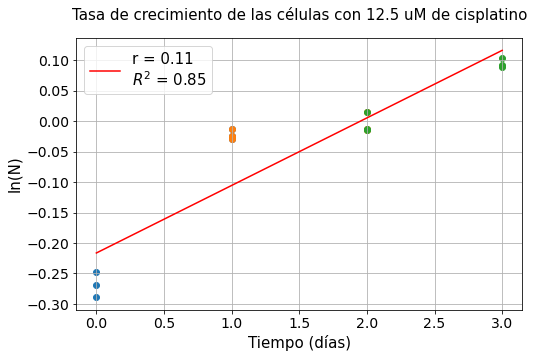

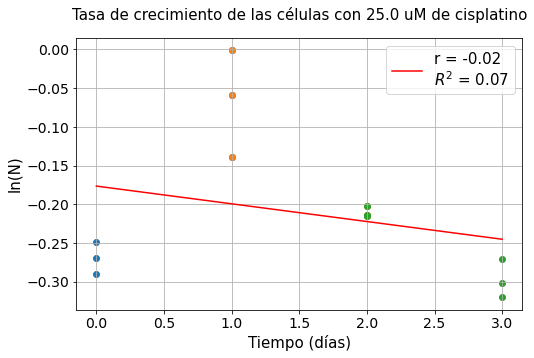

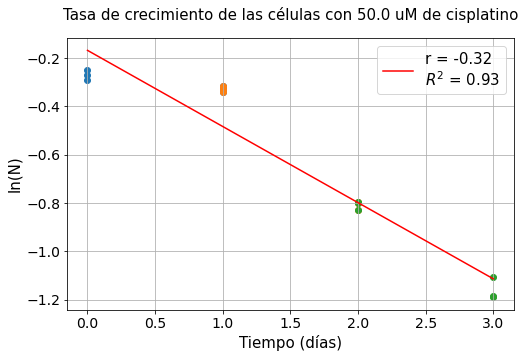

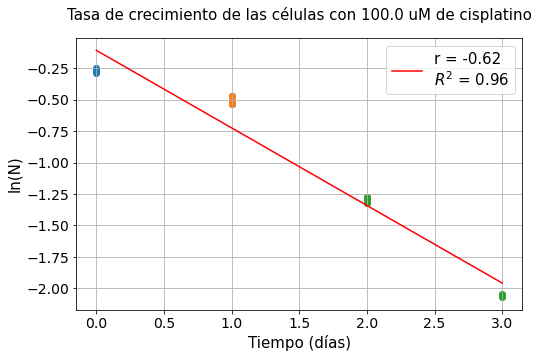

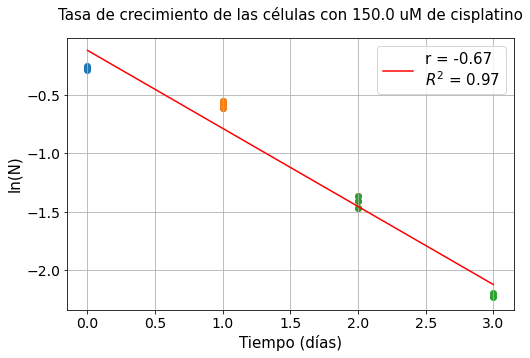

In [5]:
c = df[0].index.tolist()
mt = []
error = [] 
for i in range(len(c)):
    m,e = f.r_total(df,i)
    mt.append(m)
    error.append(e)

Observamos que solo hay un ajuste que no es bueno, que es en el que se encuentra la tasa de crecimiento 0. Esto tiene sentido porque marca el punto de inflexión entre el crecimiento y el decrecimiento. Los demás ajustes son buenos, por lo que continuamos trabajando con estos datos.

### 3. Calcular los valores de IC50 y para la tasa de crecimiento "cero"

Se obtiene un único valor de ${r_0}$ y valores de ${IC50}$ para cada tiempo.

**Para 72 horas:**

La tasa de crecimiento r0 resulta en un valor de concentración de: 20.680385460842388 uM
La tasa de crecimiento rIC50 es 0.12510363819656597 ,que resulta en un valor de IC5O de: 12.33396789148385 uM


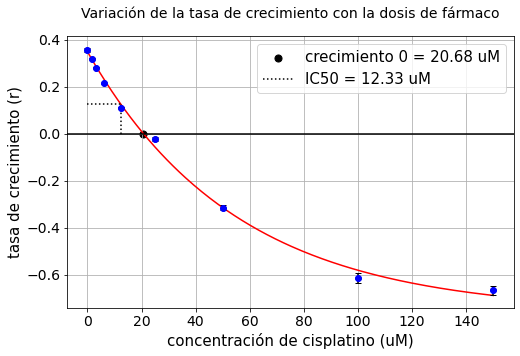

(20.680385460842388, 12.33396789148385)

In [6]:
f.ic50_r0(mt,c,3,error)

**Para 48 horas:**

La tasa de crecimiento r0 resulta en un valor de concentración de: 20.680385460842388 uM
La tasa de crecimiento rIC50 es 0.009579108103241751 ,que resulta en un valor de IC5O de: 19.994432508933095 uM


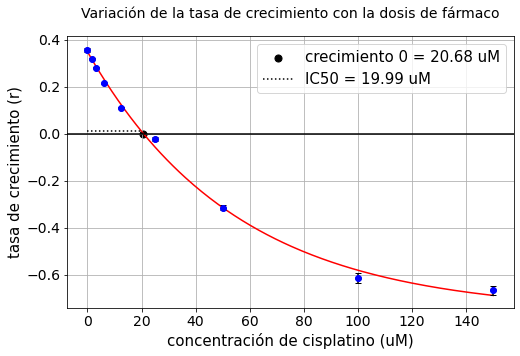

(20.680385460842388, 19.994432508933095)

In [7]:
f.ic50_r0(mt,c,2,error)

**Para 24 horas:**

La tasa de crecimiento r0 resulta en un valor de concentración de: 20.680385460842388 uM
La tasa de crecimiento rIC50 es -0.3369944821767309 ,que resulta en un valor de IC5O de: 52.74936555615917 uM


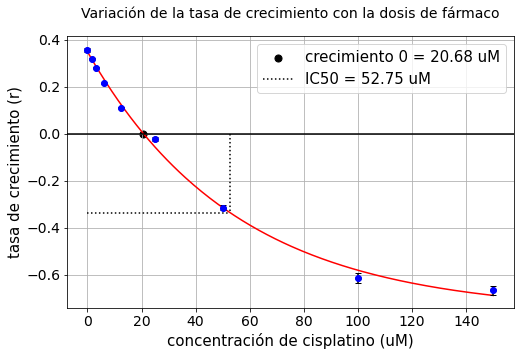

In [8]:
r,x=f.ic50_r0(mt,c,1,error)

### 4. Trabajar con las tasas de crecimiento por tramos

También se podrían trabajar los datos en los distintos tramos de tiempo, aunque creemos que trabajar con las tasas totales para el cálculo del ${IC50}$ y ${r_0}$ da mayor robustez al resultado. 

De esta forma se obtendrá distinto valor de ${IC50}$ y ${r_0}$ según a qué tiempo se calcule. 

Es muy fácil que haya pequeñas variaciones que al trabajar a tramos sean más notables y nos den resultados más inconstantes. Además de que en los primeros intervalos de tiempo, no se habrá alcanzado la viabilidad del 50% de las células, lo que nos dará resultados extremadamente grandes de IC50.

In [9]:
r1,r2,r3,c = f.r_tramos(df)

De esta forma obtengo:
- r1: tasas de crecimiento de 0 a 24 horas
- r2: tasas de crecimiento de 24 a 48 horas
- r3: tasas de crecimiento de 48 a 72 horas
- c: concentraciones de cisplatino (uM)

Si quiero ver la representación, uso la función: `r_tramos_representacion`, ya que guarda las gráficas en la carpeta "tasas de crecimiento a tramos"

In [10]:
r1,r2,r3,c = f.r_tramos_representacion(df)

**Para 72 horas:**

La tasa de crecimiento r0 resulta en un valor de concentración de: 19.893789131730593 uM
La tasa de crecimiento rIC50 es 0.25958194446556926 ,que resulta en un valor de IC5O de: 7.5292336383433 uM


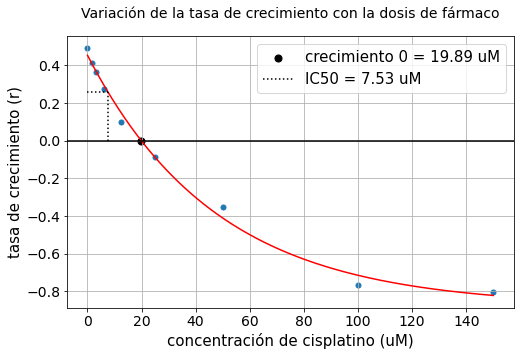

(19.893789131730593, 7.5292336383433)

In [11]:
f.ic50_r0(r3,c,3)

**Para 48 horas:**

La tasa de crecimiento r0 resulta en un valor de concentración de: 12.574433787897181 uM
La tasa de crecimiento rIC50 es -0.20828045547605667 ,que resulta en un valor de IC5O de: 26.989447672959475 uM


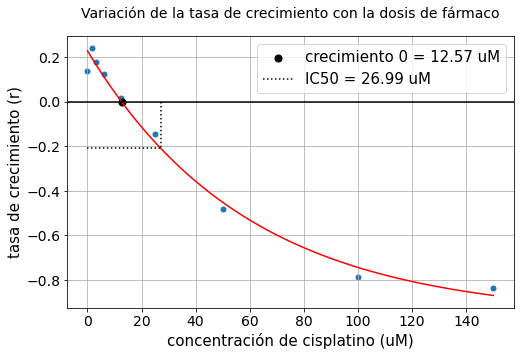

(12.574433787897181, 26.989447672959475)

In [12]:
f.ic50_r0(r2,c,2)

**Para 24 horas:**

La tasa de crecimiento r0 resulta en un valor de concentración de: 43.482847072390214 uM
La tasa de crecimiento rIC50 es -0.18099337034000262 ,que resulta en un valor de IC5O de: 82.33416915823706 uM


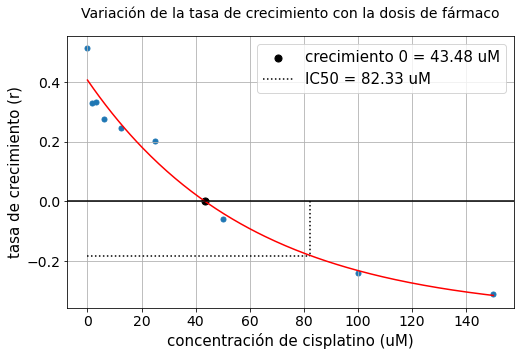

(43.482847072390214, 82.33416915823706)

In [13]:
f.ic50_r0(r1,c,1)